# NaiveBayes on Amazon Fine Food Reviews Analysis


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import datasets, neighbors



C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Using sqlite3 to retrieve data from sqlite file

con = sqlite3.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
df = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [3]:
df.sort_values('Time', ascending=False, inplace=True)

In [7]:
df_data=df[ :100000]
df_data.shape


(100000, 12)

In [8]:
X = df_data['CleanedText']
y = df_data['Score']

## Creating alogorithm on Multinomial naive bayes

In [9]:
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
import decimal
# creating  list of alpha for naive bayes
def naive_bayes(x_train,y_train):
   # alpha_values=list(np.float_(alpha_values))
    #alpha_values = list(range(10**-5,10**4,10))
    
    alpha_values=[10**-5, 10**-4,10**-3,0.05,0.01,0.1,0.5,1,5,10,50,100,500,10**3,10**4]
    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for alpha in alpha_values:
        NB = MultinomialNB(alpha=alpha)
        #NB.fit(x_train,y_train)
        f1_scorer = make_scorer(f1_score, pos_label="positive")
        scores = cross_val_score(NB, x_train, y_train, cv=10,scoring=f1_scorer)
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best alpha
    optimal_alpha = alpha_values[MSE.index(min(MSE))]
    print('\nThe optimal alpha is %d.' % optimal_alpha)

    # plot misclassification error vs alpha 
    plt.plot(alpha_values, MSE)

    #for xy in zip(laplace, np.round(MSE,3)):
        #plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('alpha')
    plt.ylabel('Misclassification Error')
    plt.show()

    #print("the misclassification error for each alpha value is : ", np.round(MSE,3))
    return optimal_alpha

In [10]:

# split the data set into crossvalidation train and test
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(70000,) (70000,) (30000,) (30000,)


# [7.2.2] Bag of Words (BoW)

In [11]:
count_vect = CountVectorizer() #in scikit-learn
X_trainbow = count_vect.fit_transform(X_train)
X_testbow = count_vect.transform(X_test)



The optimal alpha is 1.


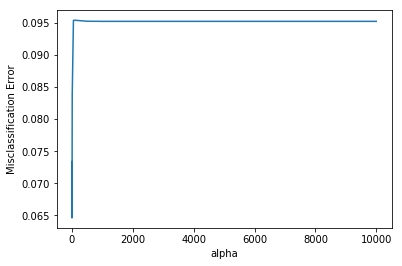

1

In [55]:
optimal_alpha_bow = naive_bayes(X_trainbow, y_train)
optimal_alpha_bow

In [12]:
# instantiate learning model alpha = optimal_alpha
nb_optimal =  MultinomialNB(alpha = 1)

# fitting the model
nb_optimal.fit(X_trainbow, y_train)

# predict the response
pred_bow = nb_optimal.predict(X_testbow)

In [13]:
# Accuracy on train data
train_acc_bow = nb_optimal.score(X_trainbow, y_train)*100
print("Train accuracy", train_acc_bow)
# Error on train data
train_err_bow = 100-train_acc_bow
print("Train Error %f%%" % (train_err_bow))
# evaluate accuracy
acc_bow = accuracy_score(y_test, pred_bow) * 100
print('\nThe accuracy of the naive bayes classifier for alpha is %f%%' % (acc_bow))
test_err_bow=100-acc_bow
print("Test Error %f%%" % (test_err_bow))

Train accuracy 91.25714285714285
Train Error 8.742857%

The accuracy of the naive bayes classifier for alpha is 89.836667%
Test Error 10.163333%


In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_bow))

             precision    recall  f1-score   support

   negative       0.73      0.65      0.69      5148
   positive       0.93      0.95      0.94     24852

avg / total       0.89      0.90      0.90     30000



##### Feature Importance

In [14]:
bow_features = count_vect.get_feature_names()

In [15]:
# To count feature for each class while fitting the model
# Number of samples encountered for each (class, feature) during fitting

feat_count = nb_optimal.feature_count_
feat_count.shape

(2, 31637)

In [16]:
# Number of samples encountered for each class during fitting

nb_optimal.class_count_

array([12249., 57751.])

In [17]:
# Empirical log probability of features given a class(i.e. P(x_i|y))

log_prob = nb_optimal.feature_log_prob_
log_prob

array([[-13.20137232, -12.50822514, -13.20137232, ..., -13.20137232,
        -13.20137232, -13.20137232],
       [-13.23259934, -14.6188937 , -13.92574652, ..., -13.92574652,
        -13.92574652, -13.92574652]])

In [123]:
class_labels=nb_optimal.classes_
class_labels

array(['negative', 'positive'], dtype='<U8')

In [75]:

class_labels = nb_optimal.classes_
topn_class1 = sorted(zip(nb_optimal.feature_log_prob_[0], bow_features),reverse=True)[:50]
topn_class2 = sorted(zip(nb_optimal.feature_log_prob_[1], bow_features),reverse=True)[:50]
print("Important words in negative reviews")
for coef, feat in topn_class1:
    print(class_labels[0], coef, feat)
print("-----------------------------------------")
print("Important words in positive reviews")
for coef, feat in topn_class2:
    print(class_labels[1], coef, feat)

Important words in negative reviews
negative -4.88428659060754 tast
negative -4.988568838852363 product
negative -5.029143622558445 like
negative -5.356303707419791 would
negative -5.369438144370479 coffe
negative -5.401237052249224 flavor
negative -5.42555499831354 one
negative -5.4874664490908005 buy
negative -5.529170222931248 tri
negative -5.539224920116365 order
negative -5.649960764101683 disappoint
negative -5.666845724975039 dont
negative -5.679681174625852 get
negative -5.693937542456098 use
negative -5.694454841141817 tea
negative -5.6988015114188135 box
negative -5.7255319318138005 good
negative -5.733575548395782 dog
negative -5.75254156394405 food
negative -5.7828001076614495 even
negative -5.801224618316605 bag
negative -5.825134898960586 packag
negative -5.831521658841135 bad
negative -5.8730565261160015 look
negative -5.893485038861125 purchas
negative -5.908818922751646 review
negative -5.925243031390557 time
negative -5.928270665449536 money
negative -5.94805800317446

In [70]:
import itertools
merged1 = list(itertools.chain.from_iterable(topn_class1))
merged2 = list(itertools.chain.from_iterable(topn_class2))

In [71]:
from collections import defaultdict
d = defaultdict(list)
for x in merged1:
    d[type(x)].append(x)
neg_text=d[str]

d1 = defaultdict(list)
for x in merged2:
    d1[type(x)].append(x)
pos_text=d1[str]

In [72]:
str1=" ".join(neg_text)
str2=" ".join(pos_text)

#### Wordcloud of Negative Features

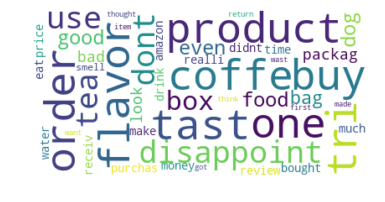

In [73]:
#Sourcecode:https://www.datacamp.com/community/tutorials/wordcloud-python
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(str1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Wordcloud of Positive Features

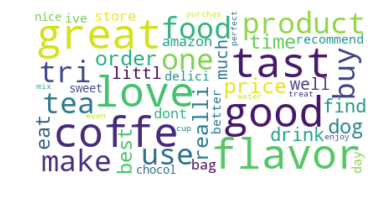

In [74]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(str2)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Confusion matrix

In [51]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_bow)

array([[ 3365,  1783],
       [ 1266, 23586]], dtype=int64)

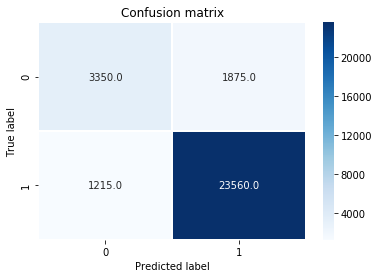

In [67]:
import seaborn as sns
def plot_confusion_matrix(targets, predictions,title='Confusion matrix', cmap="Blues"):
    """Plot Confusion Matrix."""
    cm = confusion_matrix(targets, predictions)
   # cm = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
    df = pd.DataFrame(data=cm)
    g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap=cmap)
    g.set_title(title)
    g.set_ylabel('True label')
    g.set_xlabel('Predicted label')
    return g
plot_confusion_matrix(y_test, pred_bow)

# [7.2.5] TF-IDF

In [52]:
from sklearn import preprocessing

tfidf = TfidfVectorizer()
X_traintfidf = tfidf.fit_transform(X_train)
#Normalize Data
#X_traintfidf = preprocessing.normalize(X_traintfidf)
print("Train Data Size: ",X_traintfidf.shape)
X_testtfidf = tfidf.transform(X_test)
#Normalize Data
#X_testtfidf = preprocessing.normalize(X_testtfidf)
print("Test Data Size: ",X_testtfidf.shape)


Train Data Size:  (70000, 31637)
Test Data Size:  (30000, 31637)



The optimal alpha is 0.


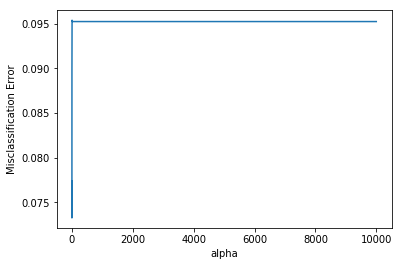

0.05

In [69]:
optimal_alpha_tfidf = naive_bayes(X_traintfidf, y_train)
optimal_alpha_tfidf

In [53]:
# instantiate learning model alpha = optimal_alpha
nb_optimal =  MultinomialNB(alpha = 0.05)

# fitting the model
nb_optimal.fit(X_traintfidf, y_train)

# predict the response
pred_tfidf = nb_optimal.predict(X_testtfidf)

In [71]:
# Accuracy on train data
train_acc_tfidf = nb_optimal.score(X_traintfidf, y_train)*100
print("Train accuracy", train_acc_tfidf)
# Error on train data
train_err_tfidf = 100-train_acc_tfidf
print("Train Error %f%%" % (train_err_tfidf))
# evaluate accuracy
acc_tfidf = accuracy_score(y_test, pred_tfidf) * 100
print('\nThe accuracy of the naive bayes classifier for alpha is %f%%' % (acc_tfidf))
test_err_tfidf=100-acc_tfidf
print("Test Error %f%%" % (test_err_tfidf))

Train accuracy 90.01714285714286
Train Error 9.982857%

The accuracy of the naive bayes classifier for alpha is 86.893333%
Test Error 13.106667%


##### Feature Impotance

In [54]:
# To get all the features name 

tfidf_features = tfidf.get_feature_names()

In [55]:
# To count feature for each class while fitting the model
# Number of samples encountered for each (class, feature) during fitting

feat_count = nb_optimal.feature_count_
feat_count.shape

(2, 31637)

In [58]:
# Empirical log probability of features given a class(i.e. P(x_i|y))

log_prob = nb_optimal.feature_log_prob_
log_prob

array([[-14.00992996, -12.4958346 , -14.00992996, ..., -14.00992996,
        -14.00992996, -14.00992996],
       [-12.67886377, -15.51270993, -14.09989198, ..., -13.75407785,
        -13.34824467, -13.8127387 ]])

In [76]:
class_labels = nb_optimal.classes_
feature_names =tfidf.get_feature_names()
topn_class1 = sorted(zip(nb_optimal.feature_log_prob_[0], tfidf_features),reverse=True)[:50]
topn_class2 = sorted(zip(nb_optimal.feature_log_prob_[1], tfidf_features),reverse=True)[:50]
print("Important words in negative reviews")
for coef, feat in topn_class1:
    print(class_labels[0], coef, feat)
print("-----------------------------------------")
print("Important words in positive reviews")
for coef, feat in topn_class2:
    print(class_labels[1], coef, feat)

Important words in negative reviews
negative -4.88428659060754 tast
negative -4.988568838852363 product
negative -5.029143622558445 like
negative -5.356303707419791 would
negative -5.369438144370479 coffe
negative -5.401237052249224 flavor
negative -5.42555499831354 one
negative -5.4874664490908005 buy
negative -5.529170222931248 tri
negative -5.539224920116365 order
negative -5.649960764101683 disappoint
negative -5.666845724975039 dont
negative -5.679681174625852 get
negative -5.693937542456098 use
negative -5.694454841141817 tea
negative -5.6988015114188135 box
negative -5.7255319318138005 good
negative -5.733575548395782 dog
negative -5.75254156394405 food
negative -5.7828001076614495 even
negative -5.801224618316605 bag
negative -5.825134898960586 packag
negative -5.831521658841135 bad
negative -5.8730565261160015 look
negative -5.893485038861125 purchas
negative -5.908818922751646 review
negative -5.925243031390557 time
negative -5.928270665449536 money
negative -5.94805800317446

In [62]:
import itertools
merged1 = list(itertools.chain.from_iterable(topn_class1))
merged2 = list(itertools.chain.from_iterable(topn_class2))

In [63]:
from collections import defaultdict
d = defaultdict(list)
for x in merged1:
    d[type(x)].append(x)
neg_text=d[str]

d1 = defaultdict(list)
for x in merged2:
    d1[type(x)].append(x)
pos_text=d1[str]

In [64]:
str1=" ".join(neg_text)
str2=" ".join(pos_text)

#### Wordcloud of Negative Features

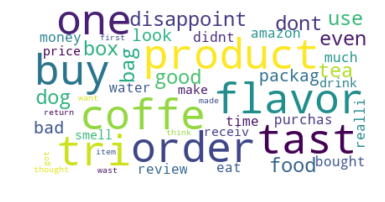

In [65]:

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(str1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Wordcloud of Positive Features

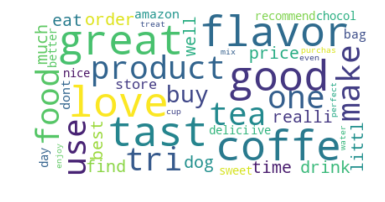

In [66]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(str2)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Confusion Matrix

In [77]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_tfidf)

array([[ 1511,  3714],
       [  218, 24557]], dtype=int64)

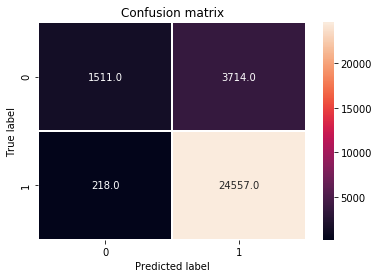

In [78]:
import seaborn as sns
def plot_confusion_matrix(targets, predictions,title='Confusion matrix'):
    """Plot Confusion Matrix."""
    cm = confusion_matrix(targets, predictions)
   # cm = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
    df = pd.DataFrame(data=cm)
    g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5)
    g.set_title(title)
    g.set_ylabel('True label')
    g.set_xlabel('Predicted label')
    return g
plot_confusion_matrix(y_test, pred_tfidf)

In [79]:
tn, fp, fn, tp = confusion_matrix(y_test,pred_tfidf).ravel()
tn,fp,fn,tp
                                   

(1511, 3714, 218, 24557)

In [80]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_tfidf))

             precision    recall  f1-score   support

   negative       0.87      0.29      0.43      5225
   positive       0.87      0.99      0.93     24775

avg / total       0.87      0.87      0.84     30000



## Conclusions

1)Naive bayes are good at text classification task like spam filtering, sentimental analysis, RS etc..

2)Multinomial Naive Bayes does not work with negative values.

3)Naive Bayes fails miserably with featurization of Word2Vec and tfidf Word2Vec as Word2Vec feature are completely dependent while Naive Bayes is based on assumption of feature independence.

In [81]:
# model
models = pd.DataFrame({'Model': ['Bow', "TFIDF"],
                       'Hyper Parameter(alpha)': [optimal_alpha_bow , optimal_alpha_tfidf], 
                       'Test Error': [test_err_bow,test_err_tfidf],
                       'Train Error': [train_err_bow,train_err_tfidf],
                       'Accuracy': [acc_bow, acc_tfidf]},
                      columns = ["Model", "Hyper Parameter(alpha)", "Test Error","Train Error","Accuracy"])
models.sort_values(by='Accuracy', ascending=False)

,Model,Hyper Parameter(alpha),Test Error,Train Error,Accuracy
0,Bow,1.00,10.300000,8.771429,89.700000
1,TFIDF,0.05,13.106667,9.982857,86.893333
